In [1]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [14]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t = sp.symbols('k omega p_0 p_0_x phi v x t')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.cos(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, p_0, phi, C = parameters
    return p_0*np.cos(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k)

In [15]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0
def invals_vastex(x,y):
    return [0,0,0,0]

In [16]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None, detailed_logs = False):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    def invals_amplitude(x,y):
        if invals is None:
            return [0,0,0,0]
        else:
            return invals
    
    P_0_x = []
    omega_x = []
    for xval in range(len(X)):
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs)
        print('\n\n')
        print(tijdfit, 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        #plot het boeltje om te testen
        fig, ax = plt.subplots(1,1)
        ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', fmt = "o" ,zorder = 1)
        T_fit = np.linspace(0, max(tijd),300)
        druk_fit = tijdfit[1][0]*np.cos(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
        ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)
        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('T (s)')
        ax.legend("druk in functie van tijd")
        ax.legend()
        plt.tight_layout()
        plt.show()


    OMEGA = functies.mu_sigma(omega_x, omega)

    
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR, detailed_logs = False):
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_vastex, X, P_0_x, P_0_x_ERR, detailed_logs= detailed_logs)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None, detailed_logs = False):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, detailed_logs = detailed_logs)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR), detailed_logs = detailed_logs)

    x_fit = np.linspace(0,max(X))
    druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
    #plot het boeltje
    fig, ax = plt.subplots(1,1)
    ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')

    ax.plot(x_fit, druk_fit, label = 'model')

    ax.set_ylabel('$V_0$ [mV]')
    ax.set_xlabel('x (m)')
    ax.legend("drukamplitude in functie van positie")
    ax.legend()
    plt.tight_layout()
    plt.show()

    #bereken de snelheid
    snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)
    print(snelheid)

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.9500955234598305e-08
             x: [-3.500e-01  4.897e-05 -4.501e-01  1.122e+00]
           nit: 126
          nfev: 222
 final_simplex: (array([[-3.500e-01,  4.897e-05, -4.501e-01,  1.122e+00],
                       [-3.500e-01, -4.915e-05, -4.500e-01,  1.122e+00],
                       ...,
                       [-3.500e-01, -1.931e-05, -4.500e-01,  1.122e+00],
                       [-3.500e-01,  6.882e-05, -4.501e-01,  1.122e+00]]), array([ 4.950e-08,  6.047e-08,  7.090e-08,  7.444e-08,
                        8.302e-08]))
[[32.701212824259635, 21.702360342308445], [0.4808115771258387, 0.48081157712583866], [33.08104242977458, 34.937631545731314], [0.8159057094571417, 1.428795410900792]]
omega heeft als waarde: -0.35004 + 22.052 - -33.051 met 68% betrouwbaarheidsinterval: [32.701, 21.702] 
p_0_x heeft als waarde: 4.8975e-05 + 0.48076 - -0.48076 met 68% betr

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


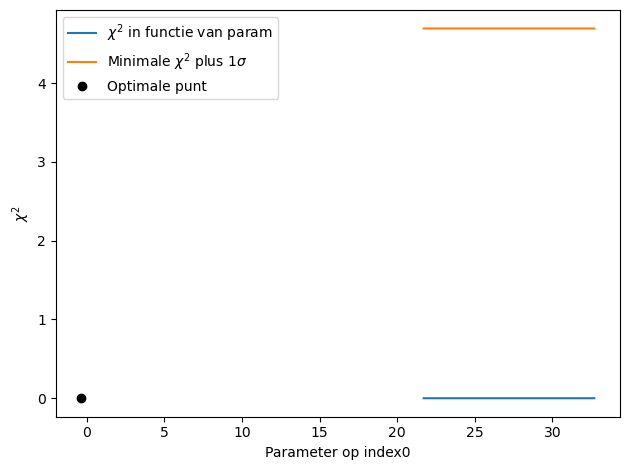

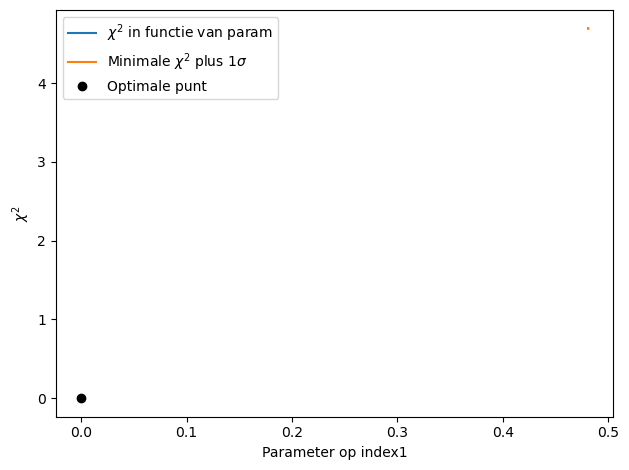

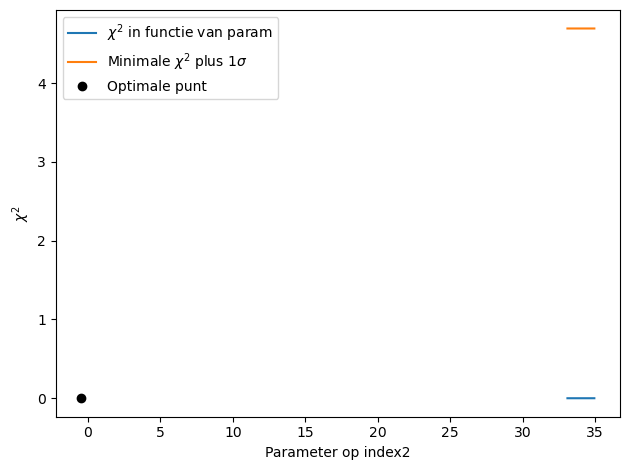

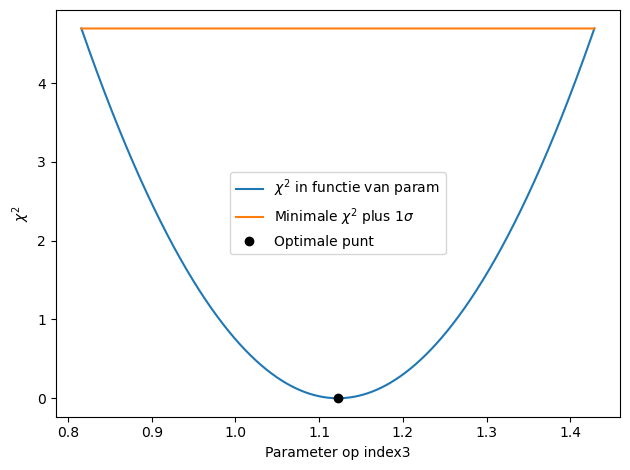

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 1.0761e-09



[[-0.35003807003723303, (-33.0, 22.0), 'S'], [4.897481548754568e-05, 0.48, 'S'], [-0.45008220992890585, 35.0, 'S'], [1.1223628671638965, 0.31, 'S']] tijdfit


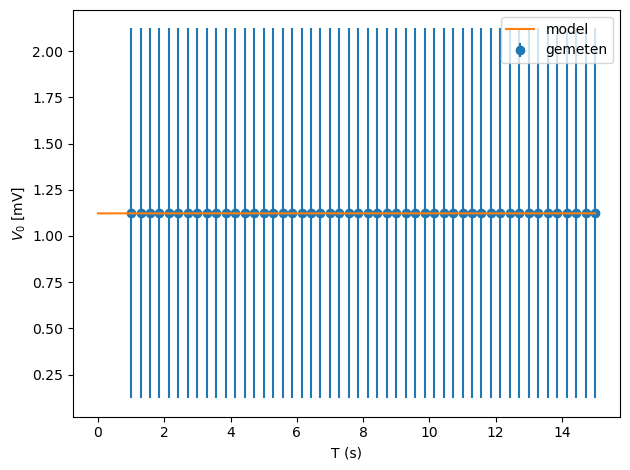

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.1089383601736693e-08
             x: [-1.000e+00 -5.000e-01  1.712e+00  1.044e+00]
           nit: 442
          nfev: 731
 final_simplex: (array([[-1.000e+00, -5.000e-01,  1.712e+00,  1.044e+00],
                       [-1.000e+00, -5.000e-01,  1.712e+00,  1.044e+00],
                       ...,
                       [-1.000e+00, -5.000e-01,  1.712e+00,  1.044e+00],
                       [-1.000e+00, -5.000e-01,  1.712e+00,  1.044e+00]]), array([ 1.109e-08,  1.189e-08,  1.435e-08,  2.282e-08,
                        2.512e-08]))
[[-3.745052917191817, -0.04530480984580224], [-0.9485316260949006, -0.05147155697235179], [0.8285241929774972, 2.5821795353690007], [0.737720159798396, 1.3506098607478623]]
omega heeft als waarde: -1 + 0.9547 - 2.745 met 68% betrouwbaarheidsinterval: [-3.7451, -0.045305] 
p_0_x heeft als waarde: -0.50002 + 0.44855 - 0.44851 met 68% betrou

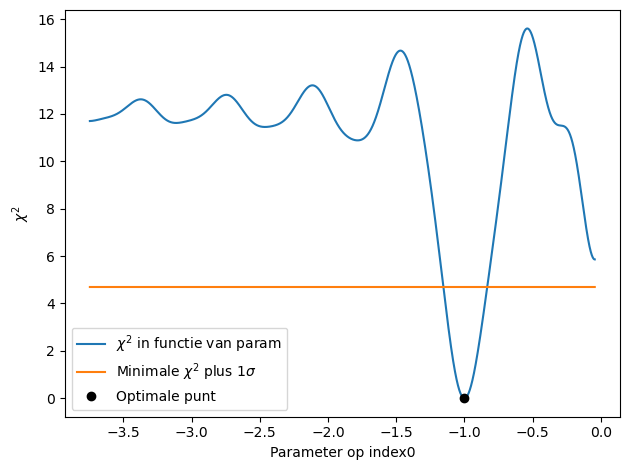

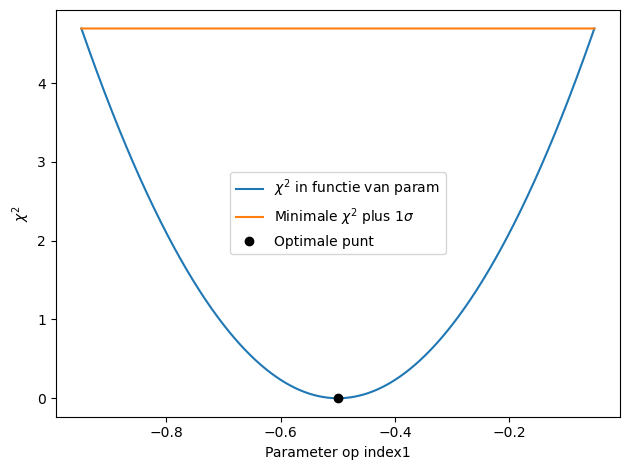

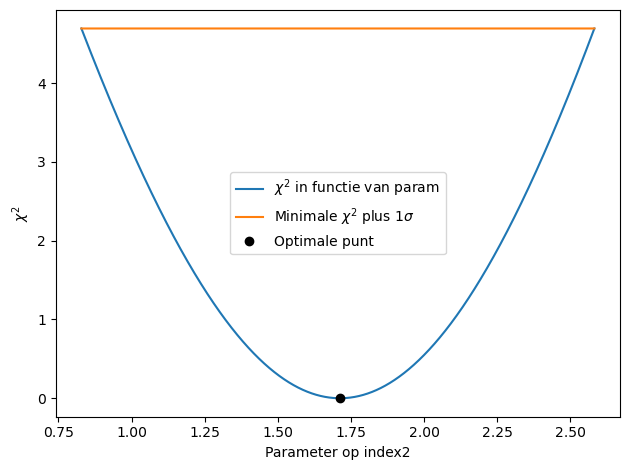

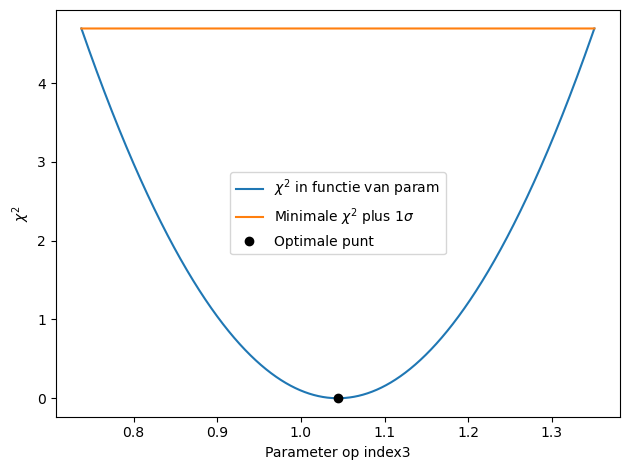

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 2.4107e-10



[[-1.0000056145892193, (2.7, 0.95), 'S'], [-0.5000197617637618, 0.45, 'S'], [1.7124066235009021, 0.88, 'S'], [1.0441651576967015, 0.31, 'S']] tijdfit


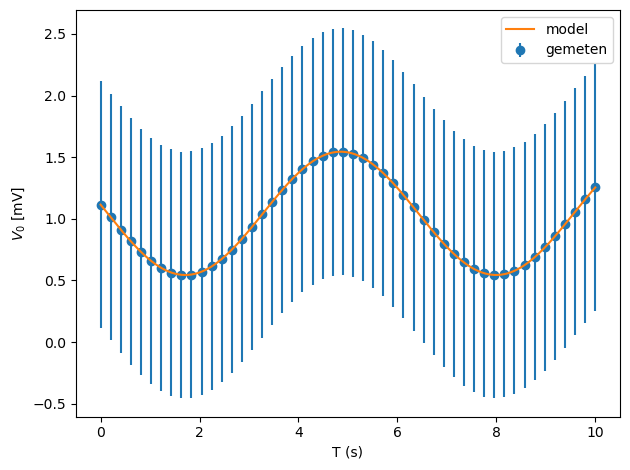

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.8316287735484312e-08
             x: [-1.000e+00  1.000e+00  2.354e+00  4.321e-06]
           nit: 401
          nfev: 672
 final_simplex: (array([[-1.000e+00,  1.000e+00,  2.354e+00,  4.321e-06],
                       [-1.000e+00,  1.000e+00,  2.353e+00, -5.700e-06],
                       ...,
                       [-1.000e+00,  1.000e+00,  2.354e+00,  2.130e-05],
                       [-1.000e+00,  9.999e-01,  2.353e+00,  2.524e-05]]), array([ 1.832e-08,  6.058e-08,  6.225e-08,  9.003e-08,
                        1.041e-07]))
[[-10.29546256096299, -0.12086353636767441], [0.5583971727383776, 1.4416024123061486], [1.9186372497641377, 2.77810703742832], [0.3064492357731493, 0.306449235773141]]
omega heeft als waarde: -1 + 0.87915 - 9.2955 met 68% betrouwbaarheidsinterval: [-10.295, -0.12086] 
p_0_x heeft als waarde: 1 + 0.4416 - 0.4416 met 68% betrouwbaarheidsint

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


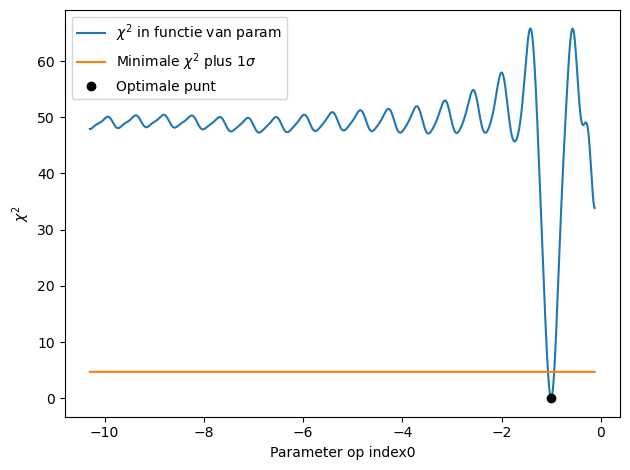

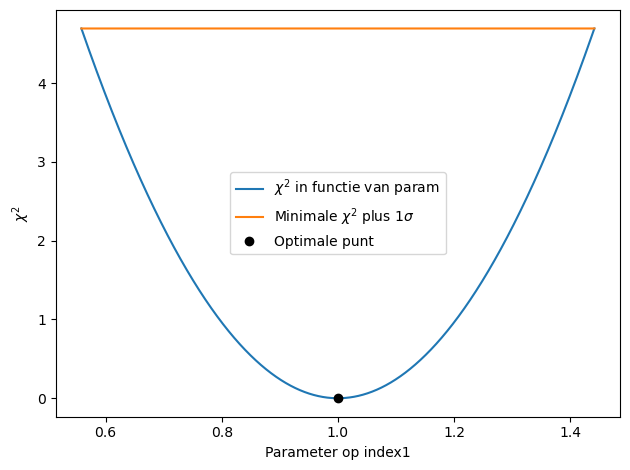

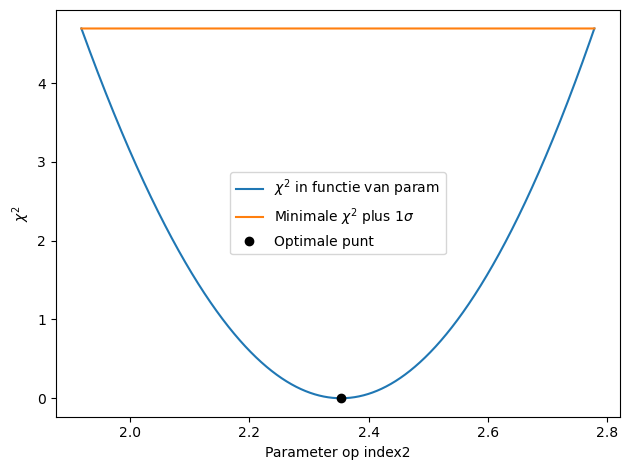

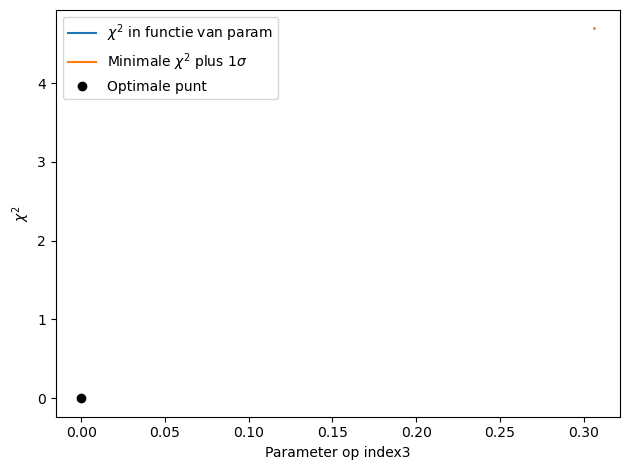

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 3.9818e-10



[[-1.000008571933892, (9.3, 0.88), 'S'], [1.000001767718837, 0.44, 'S'], [2.3535506853074004, 0.43, 'S'], [4.321214518457283e-06, 0.31, 'S']] tijdfit


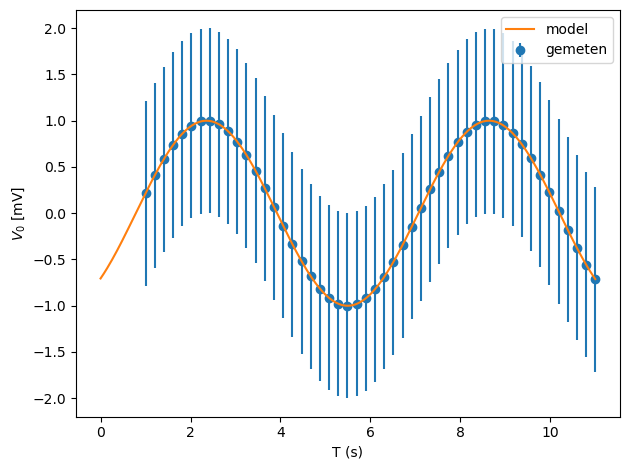

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.076870111732663e-09
             x: [-5.000e-01 -5.000e-01  2.929e+00  1.123e+00]
           nit: 374
          nfev: 620
 final_simplex: (array([[-5.000e-01, -5.000e-01,  2.929e+00,  1.123e+00],
                       [-5.000e-01, -5.000e-01,  2.929e+00,  1.123e+00],
                       ...,
                       [-5.000e-01, -5.000e-01,  2.929e+00,  1.123e+00],
                       [-5.000e-01, -5.000e-01,  2.929e+00,  1.123e+00]]), array([ 3.077e-09,  7.217e-09,  8.786e-09,  8.995e-09,
                        1.268e-08]))
[[-0.7840507259024403, -0.20001970437806318], [-0.9355843686243979, -0.06441972854298833], [2.05977635337745, 3.849951246134412], [0.8167975413935029, 1.4296872423787197]]
omega heeft als waarde: -0.5 + 0.29998 - 0.28405 met 68% betrouwbaarheidsinterval: [-0.78405, -0.20002] 
p_0_x heeft als waarde: -0.5 + 0.43558 - 0.43558 met 68% betrouw

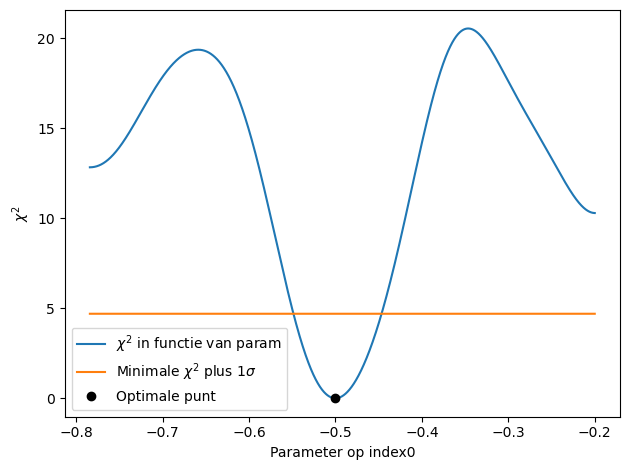

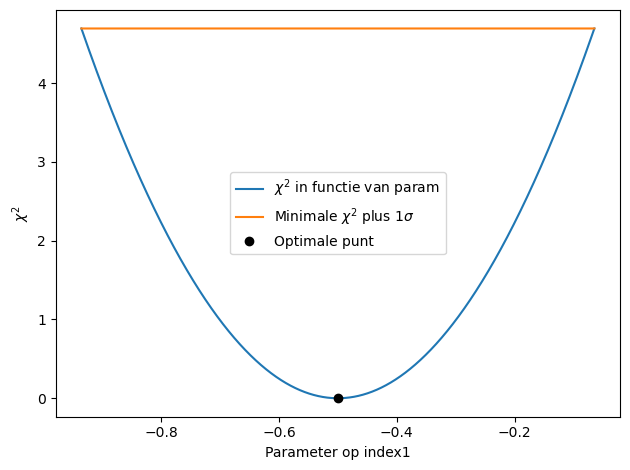

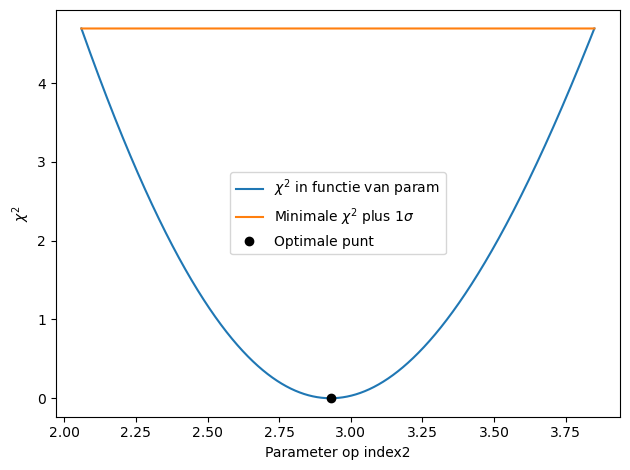

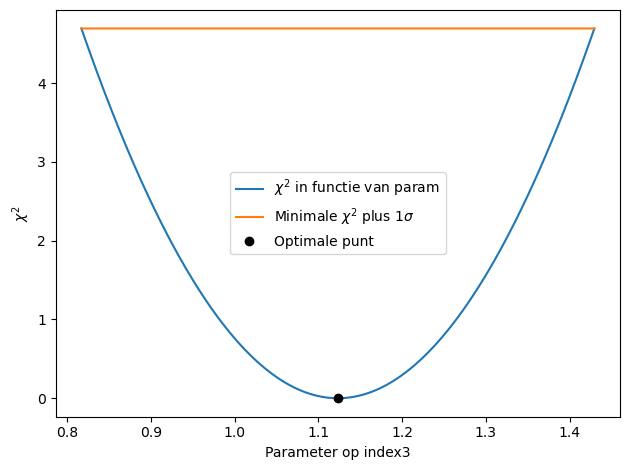

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 6.6888e-11



[[-0.4999994691477364, 0.3, 'S'], [-0.5000019873006898, 0.44, 'S'], [2.9291747952427416, 0.92, 'S'], [1.1232390786929378, 0.31, 'S']] tijdfit


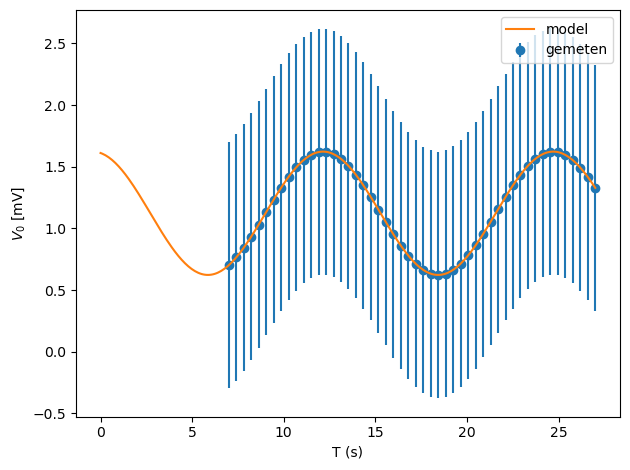

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.108508365951703e-08
             x: [ 1.911e-02  9.186e-01  2.757e-01 -2.721e-01]
           nit: 371
          nfev: 622
 final_simplex: (array([[ 1.911e-02,  9.186e-01,  2.757e-01, -2.721e-01],
                       [ 1.911e-02,  9.186e-01,  2.758e-01, -2.722e-01],
                       ...,
                       [ 1.911e-02,  9.186e-01,  2.758e-01, -2.721e-01],
                       [ 1.911e-02,  9.187e-01,  2.758e-01, -2.721e-01]]), array([ 4.109e-08,  6.529e-08,  7.099e-08,  7.314e-08,
                        8.245e-08]))
[[-0.0009516693640149005, 0.031135274958081122], [0.20086462595235866, 1.6363261127606865], [-0.43390002732319966, 3.3100146834900657], [-0.8048452910762575, 0.26055362783069025]]
k heeft als waarde: 0.019106 + 0.012029 - 0.020058 met 68% betrouwbaarheidsinterval: [-0.00095167, 0.031135] 
p_0 heeft als waarde: 0.91862 + 0.71771 - 0.71775 m

c:\Users\samfa\Python\Experimentele_vscode\functies.py:301: RuntimeWarning: divide by zero encountered in scalar divide
  chi_red = chi_min/nu


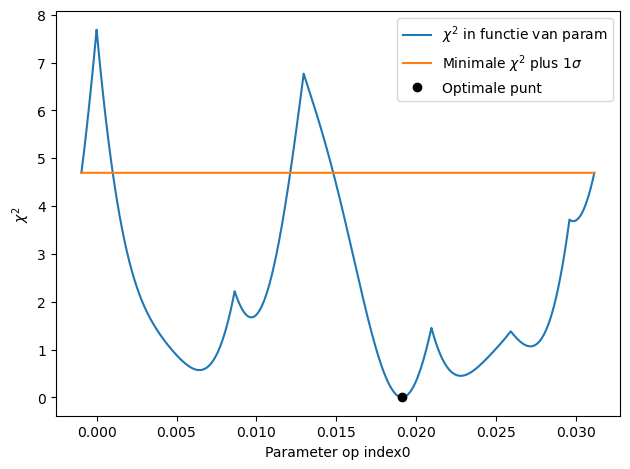

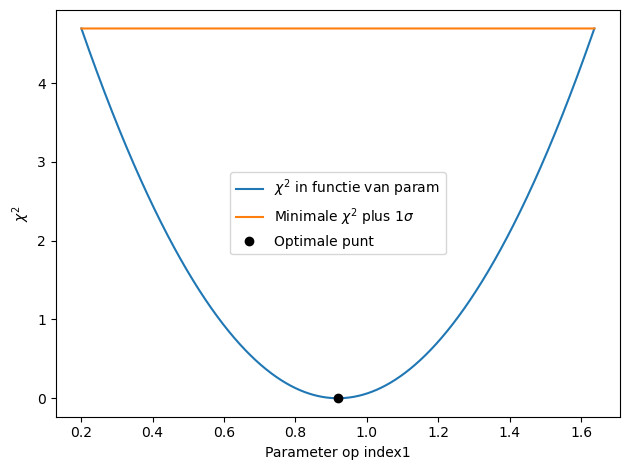

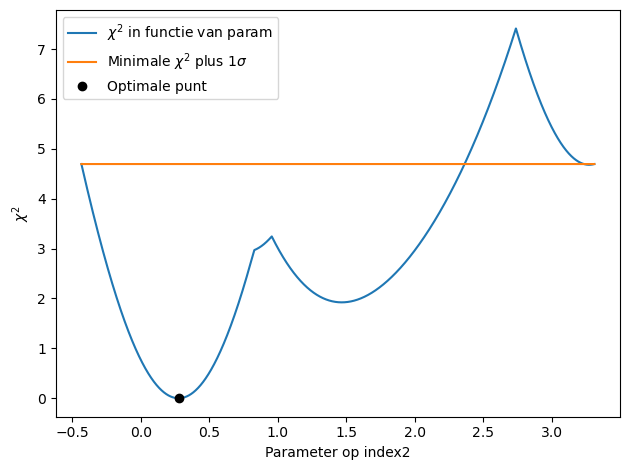

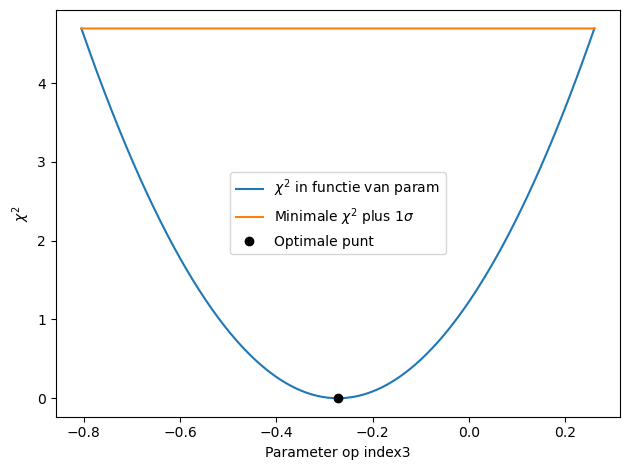

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: nan
De gereduceerde chi^2 waarde is: inf


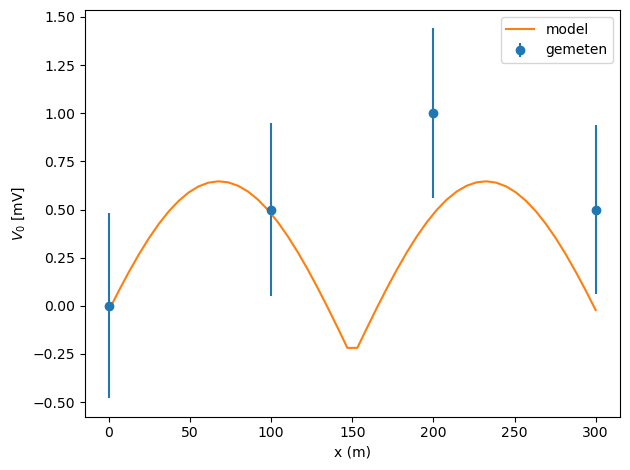

datapunt: v = [-26.4801393191911, 35.8967466235554, 'Normaal']


In [18]:
#### Hier volgt de effectieve data-analyse
fix_data(X, T, P, P_fout, detailed_logs=True)

In [62]:
def X_tractor(inhoud): #extraheert effectief nuttige data uit die txt-files
    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak
    freq = float(inhoud.split("Frequency            :		")[1][:4]) * 10**3 #het staat in kHz
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    for digit in gesplit[1]:
        if digit.isdigit():
            getal+=digit
        else:
            eenheid+=digit
            count+=1
        if count == 3:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == ".us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == ".ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    Vpart = np.array(nuttig[1])        
    C = np.sum(Vpart)/len(Vpart)
    if Vpart[0] < Vpart[1]:
        phi = np.arcsin((Vpart[0] - C)/amplitude)
    else:
        phi = np.arcsin((Vpart[0] - C)/amplitude) + np.pi
    invals = [2*np.pi*freq*10**(-5), amplitude, phi, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

In [63]:
#experiment 1: 1000 Hz, 35,3cm
mypath = "metingen laweit/1000Hz, 35.3cm"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
afstanden = []
T = []
V = []
invals = []
for filenaam in onlyfiles:
    nummer = float(filenaam[9:-4])*10**(-3)
    afstanden.append(nummer)
    bestand = open(mypath + '/' +filenaam,'rt')
    inhoud = bestand.read()
    bestand.close()
    Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
    if nummer != 0:
        assert eenheid0 == eenheid
    else:
        eenheid0 = eenheid
    V.append(Vpart.copy())
    T.append(Tpart.copy())
    invals.append(invals_vaste_x.copy())
V = np.array(V)
afstanden = np.array(afstanden)
invals = np.array(invals)
T = np.array(T)
V_fout = np.full(np.shape(V), 0.1) #euhm pls help, ik heb hier 0.1 mV genomen als de fout op de spanning


6.660176425610362e-06

3.7439977194161074

array([2.0000e-01, 4.0000e-01, 6.0000e-01, ..., 1.9996e+03, 1.9998e+03,
       2.0000e+03])

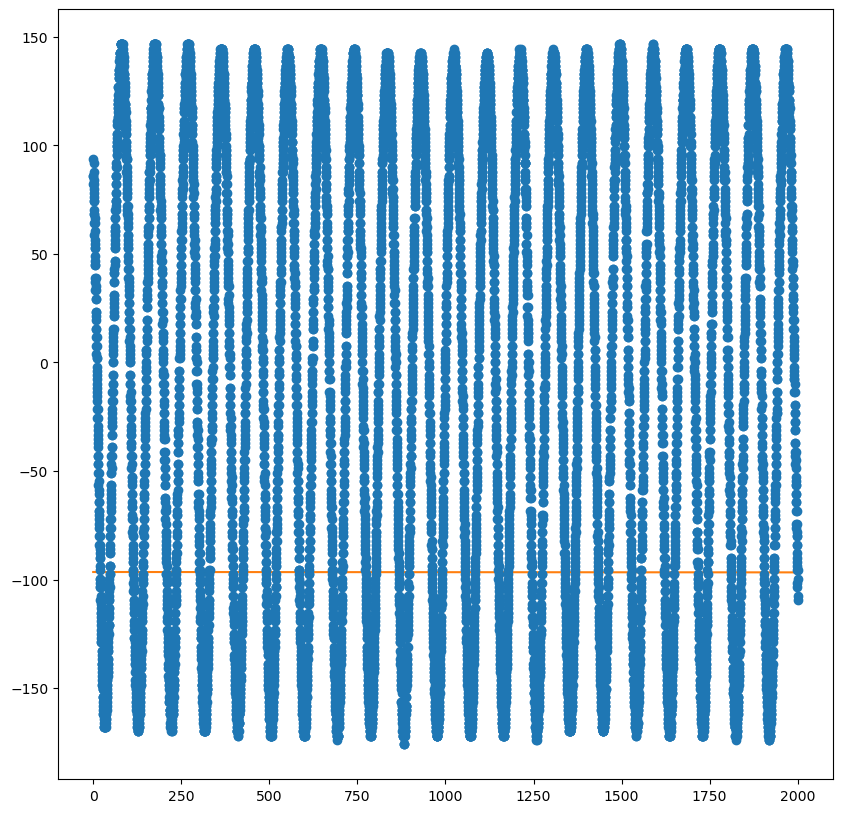

In [64]:
inval = invals[0]
display(inval[0]*0.0001)
display(inval[2])
display(T[0])
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.errorbar(T[0], V[0], yerr= V_fout[0], fmt='o')
temp = np.linspace(0,2000,10000)
ax.plot(temp, inval[1]*np.sin(inval[0]*temp*0.00001 + inval[2]) + inval[3]) 
plt.show()

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 45992502.359283894
             x: [ 6.665e-02  1.561e+02  7.210e+00 -5.238e+00]
           nit: 270
          nfev: 468
 final_simplex: (array([[ 6.665e-02,  1.561e+02,  7.210e+00, -5.238e+00],
                       [ 6.665e-02,  1.561e+02,  7.210e+00, -5.238e+00],
                       ...,
                       [ 6.665e-02,  1.561e+02,  7.210e+00, -5.238e+00],
                       [ 6.665e-02,  1.561e+02,  7.210e+00, -5.238e+00]]), array([ 4.599e+07,  4.599e+07,  4.599e+07,  4.599e+07,
                        4.599e+07]))
[[0.00047305092459589814, 0.06664615108696506], [156.0532901239684, 156.05944150839358], [-5.356317555682222, 19.776462804286115], [-5.239722009514128, -5.235388224153111]]
omega heeft als waarde: 0.066646 + 1.6943e-08 - 0.066173 met 68% betrouwbaarheidsinterval: [0.00047305, 0.066646] 
p_0_x heeft als waarde: 156.06 + 0.0030705 - 0.0030809 m

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


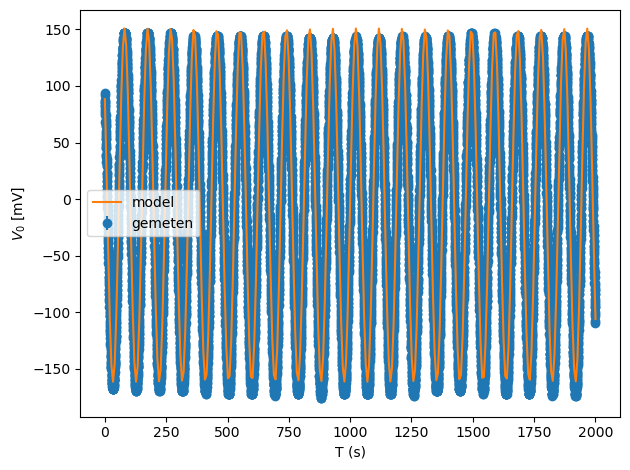

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5297200.578189445
             x: [ 6.663e-02  2.408e+01  7.841e+00  7.997e+00]
           nit: 226
          nfev: 398
 final_simplex: (array([[ 6.663e-02,  2.408e+01,  7.841e+00,  7.997e+00],
                       [ 6.663e-02,  2.408e+01,  7.841e+00,  7.997e+00],
                       ...,
                       [ 6.663e-02,  2.408e+01,  7.841e+00,  7.997e+00],
                       [ 6.663e-02,  2.408e+01,  7.841e+00,  7.997e+00]]), array([ 5.297e+06,  5.297e+06,  5.297e+06,  5.297e+06,
                        5.297e+06]))
[[0.0736978620751887, 0.06663322196806479], [24.07735592227609, 24.083490621901337], [1.5581124575509437, 14.12473735020271], [7.995305393278032, 7.999639184798429]]
omega heeft als waarde: 0.066633 + -1.0975e-07 - -0.0070645 met 68% betrouwbaarheidsinterval: [0.073698, 0.066633] 
p_0_x heeft als waarde: 24.08 + 0.0030721 - 0.0030626 met 68% b

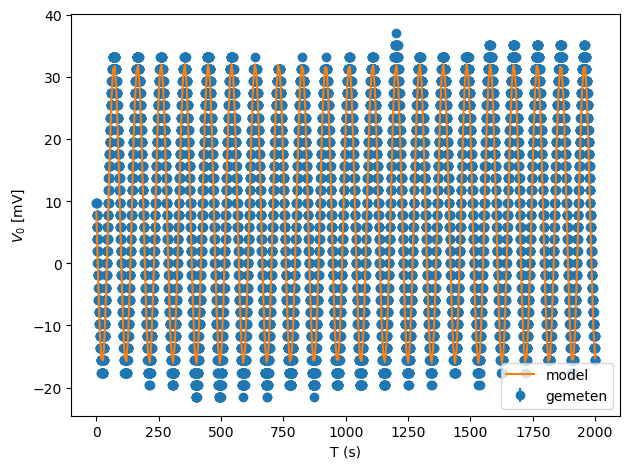

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1758997565.7337604
             x: [ 7.116e-02  1.300e+01  5.982e+00  4.850e+00]
           nit: 187
          nfev: 326
 final_simplex: (array([[ 7.116e-02,  1.300e+01,  5.982e+00,  4.850e+00],
                       [ 7.116e-02,  1.300e+01,  5.982e+00,  4.850e+00],
                       ...,
                       [ 7.116e-02,  1.300e+01,  5.982e+00,  4.850e+00],
                       [ 7.116e-02,  1.300e+01,  5.982e+00,  4.850e+00]]), array([ 1.759e+09,  1.759e+09,  1.759e+09,  1.759e+09,
                        1.759e+09]))
[[0.03496941712445917, 0.09962612274052084], [12.998674766256896, 13.004787374037079], [112.79615325225345, -19.15026554307659], [4.84798427434399, 4.852318060854453]]
omega heeft als waarde: 0.071159 + 0.028467 - 0.03619 met 68% betrouwbaarheidsinterval: [0.034969, 0.099626] 
p_0_x heeft als waarde: 13.002 + 0.0030518 - 0.0030608 met 68% bet

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


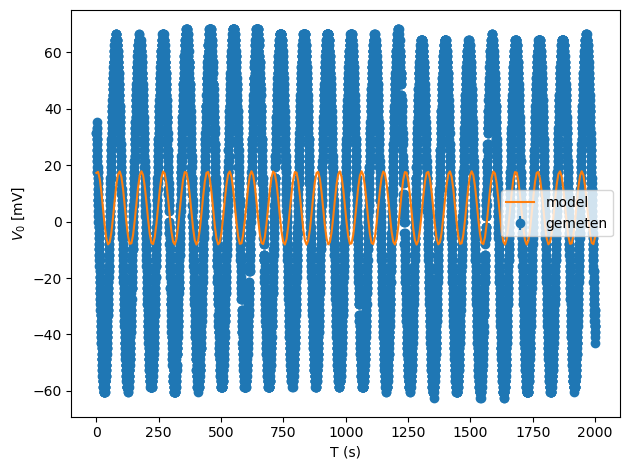

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11926429.076866865
             x: [ 6.664e-02  8.287e+01  7.247e+00  3.548e+00]
           nit: 311
          nfev: 527
 final_simplex: (array([[ 6.664e-02,  8.287e+01,  7.247e+00,  3.548e+00],
                       [ 6.664e-02,  8.287e+01,  7.247e+00,  3.548e+00],
                       ...,
                       [ 6.664e-02,  8.287e+01,  7.247e+00,  3.548e+00],
                       [ 6.664e-02,  8.287e+01,  7.247e+00,  3.548e+00]]), array([ 1.193e+07,  1.193e+07,  1.193e+07,  1.193e+07,
                        1.193e+07]))
[[0.000443726497118551, 0.10847075918329668], [82.86775152281216, 82.87390270692791], [-17.885431772488598, 19.81368006936137], [3.5459263199571303, 3.5502601191336876]]
omega heeft als waarde: 0.066644 + 0.041827 - 0.0662 met 68% betrouwbaarheidsinterval: [0.00044373, 0.10847] 
p_0_x heeft als waarde: 82.871 + 0.0030744 - 0.0030767 met 68% b

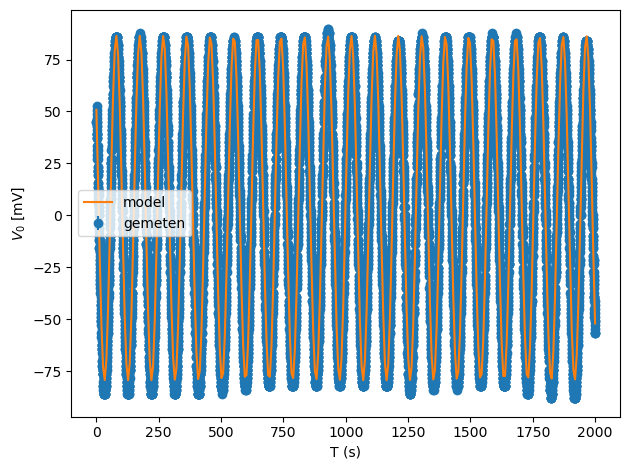

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 20066753.78703071
             x: [ 6.665e-02  1.125e+02  7.236e+00 -1.509e+00]
           nit: 300
          nfev: 503
 final_simplex: (array([[ 6.665e-02,  1.125e+02,  7.236e+00, -1.509e+00],
                       [ 6.665e-02,  1.125e+02,  7.236e+00, -1.509e+00],
                       ...,
                       [ 6.665e-02,  1.125e+02,  7.236e+00, -1.509e+00],
                       [ 6.665e-02,  1.125e+02,  7.236e+00, -1.509e+00]]), array([ 2.007e+07,  2.007e+07,  2.007e+07,  2.007e+07,
                        2.007e+07]))
[[0.00044829869874220035, 0.06664972331581606], [112.51469747650995, 112.52084876484311], [-5.330172130699171, 19.80256909900631], [-1.5107644084374816, -1.5064306233872709]]
omega heeft als waarde: 0.06665 + 2.3361e-08 - 0.066201 met 68% betrouwbaarheidsinterval: [0.0004483, 0.06665] 
p_0_x heeft als waarde: 112.52 + 0.0030688 - 0.0030824 met

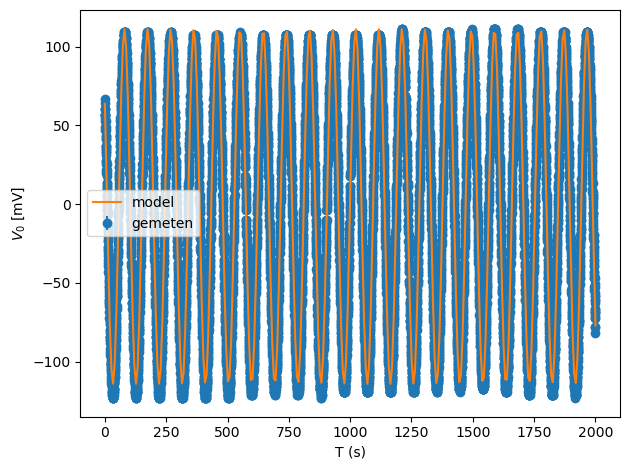

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 42035775.60991298
             x: [ 6.664e-02  1.462e+02  7.172e+00  3.193e+00]
           nit: 292
          nfev: 492
 final_simplex: (array([[ 6.664e-02,  1.462e+02,  7.172e+00,  3.193e+00],
                       [ 6.664e-02,  1.462e+02,  7.172e+00,  3.193e+00],
                       ...,
                       [ 6.664e-02,  1.462e+02,  7.172e+00,  3.193e+00],
                       [ 6.664e-02,  1.462e+02,  7.172e+00,  3.193e+00]]), array([ 4.204e+07,  4.204e+07,  4.204e+07,  4.204e+07,
                        4.204e+07]))
[[0.011841656453243922, 0.06663847540582252], [146.18361938665356, 146.18977073452098], [0.8891894674014115, 13.455601855112851], [3.190667451977031, 3.1950012401150376]]
omega heeft als waarde: 0.066638 + 1.8103e-08 - 0.054797 met 68% betrouwbaarheidsinterval: [0.011842, 0.066638] 
p_0_x heeft als waarde: 146.19 + 0.0030776 - 0.0030738 met 68

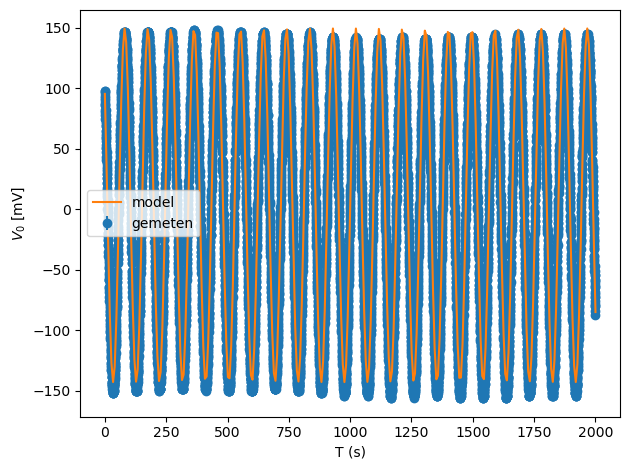

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 30322674.558253624
             x: [ 6.665e-02  1.329e+02  7.182e+00 -1.351e+00]
           nit: 296
          nfev: 504
 final_simplex: (array([[ 6.665e-02,  1.329e+02,  7.182e+00, -1.351e+00],
                       [ 6.665e-02,  1.329e+02,  7.182e+00, -1.351e+00],
                       ...,
                       [ 6.665e-02,  1.329e+02,  7.182e+00, -1.351e+00],
                       [ 6.665e-02,  1.329e+02,  7.182e+00, -1.351e+00]]), array([ 3.032e+07,  3.032e+07,  3.032e+07,  3.032e+07,
                        3.032e+07]))
[[0.0004943770931485509, 0.06665200428283367], [132.84893359394607, 132.85508510888968], [0.8984363788906127, 13.464852959557465], [-1.3532574571217173, -1.3489236700975014]]
omega heeft als waarde: 0.066652 + 1.9858e-08 - 0.066158 met 68% betrouwbaarheidsinterval: [0.00049438, 0.066652] 
p_0_x heeft als waarde: 132.85 + 0.0030654 - 0.0030861

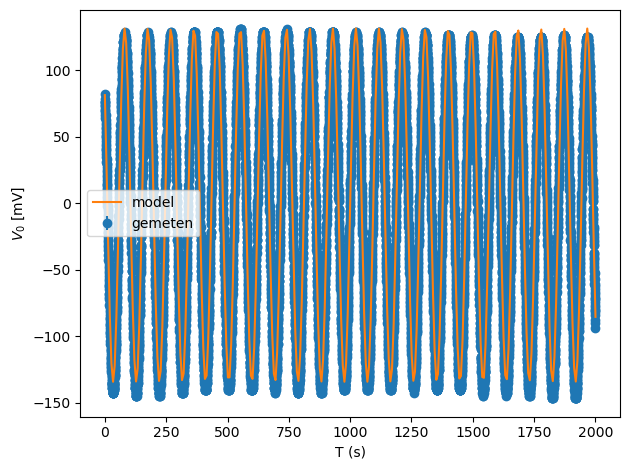

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 44107863.20574802
             x: [ 6.666e-02  1.532e+02  7.140e+00 -3.195e+00]
           nit: 260
          nfev: 450
 final_simplex: (array([[ 6.666e-02,  1.532e+02,  7.140e+00, -3.195e+00],
                       [ 6.666e-02,  1.532e+02,  7.140e+00, -3.195e+00],
                       ...,
                       [ 6.666e-02,  1.532e+02,  7.140e+00, -3.195e+00],
                       [ 6.666e-02,  1.532e+02,  7.140e+00, -3.195e+00]]), array([ 4.411e+07,  4.411e+07,  4.411e+07,  4.411e+07,
                        4.411e+07]))
[[0.011827454018584399, 0.06665680878762097], [153.15348358310013, 153.15963509719603], [-5.426743670026313, 19.70603743022658], [-3.1976067401949915, -3.1932729555732067]]
omega heeft als waarde: 0.066657 + 1.7271e-08 - 0.054829 met 68% betrouwbaarheidsinterval: [0.011827, 0.066657] 
p_0_x heeft als waarde: 153.16 + 0.003071 - 0.0030805 met 6

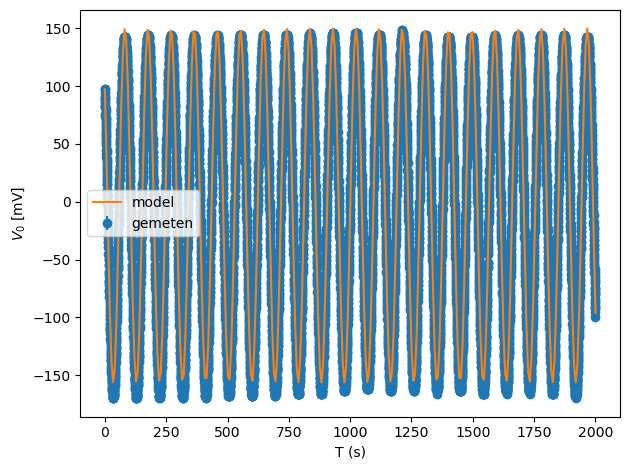

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 58137825.69167338
             x: [ 6.665e-02  1.624e+02  7.105e+00  1.589e-01]
           nit: 361
          nfev: 615
 final_simplex: (array([[ 6.665e-02,  1.624e+02,  7.105e+00,  1.589e-01],
                       [ 6.665e-02,  1.624e+02,  7.105e+00,  1.589e-01],
                       ...,
                       [ 6.665e-02,  1.624e+02,  7.105e+00,  1.589e-01],
                       [ 6.665e-02,  1.624e+02,  7.105e+00,  1.589e-01]]), array([ 5.814e+07,  5.814e+07,  5.814e+07,  5.814e+07,
                        5.814e+07]))
[[0.0005465177361506774, 0.0666521336096721], [162.41505254287003, 162.42120386094595], [-5.461173745992864, 19.67160508420114], [0.1567733173686254, 0.16110711251607412]]
omega heeft als waarde: 0.066652 + -1.6239e-08 - 0.066106 met 68% betrouwbaarheidsinterval: [0.00054652, 0.066652] 
p_0_x heeft als waarde: 162.42 + 0.0030709 - 0.0030804 me

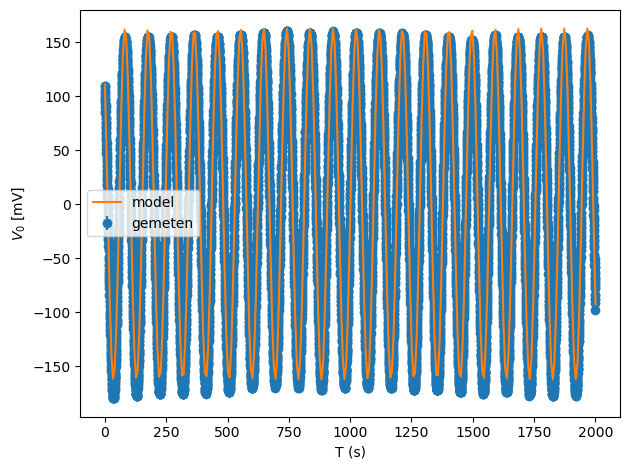

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 64022062.850139625
             x: [ 6.666e-02  1.680e+02  7.140e+00 -4.738e-01]
           nit: 270
          nfev: 471
 final_simplex: (array([[ 6.666e-02,  1.680e+02,  7.140e+00, -4.738e-01],
                       [ 6.666e-02,  1.680e+02,  7.140e+00, -4.738e-01],
                       ...,
                       [ 6.666e-02,  1.680e+02,  7.140e+00, -4.738e-01],
                       [ 6.666e-02,  1.680e+02,  7.140e+00, -4.738e-01]]), array([ 6.402e+07,  6.402e+07,  6.402e+07,  6.402e+07,
                        6.402e+07]))
[[0.0004962446214212997, 0.0666567153553628], [167.96174438127056, 167.96789589351337], [-5.426627379571005, 19.706150205920885], [-0.4759293685508635, -0.47159558014259967]]
omega heeft als waarde: 0.066657 + -1.5691e-08 - 0.06616 met 68% betrouwbaarheidsinterval: [0.00049624, 0.066657] 
p_0_x heeft als waarde: 167.96 + 0.0030744 - 0.0030771

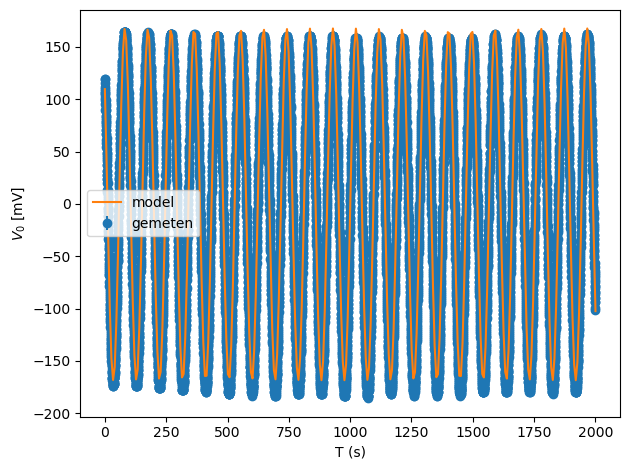

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 56589306.36799221
             x: [ 6.666e-02  1.630e+02  7.086e+00  4.126e+00]
           nit: 307
          nfev: 513
 final_simplex: (array([[ 6.666e-02,  1.630e+02,  7.086e+00,  4.126e+00],
                       [ 6.666e-02,  1.630e+02,  7.086e+00,  4.126e+00],
                       ...,
                       [ 6.666e-02,  1.630e+02,  7.086e+00,  4.126e+00],
                       [ 6.666e-02,  1.630e+02,  7.086e+00,  4.126e+00]]), array([ 5.659e+07,  5.659e+07,  5.659e+07,  5.659e+07,
                        5.659e+07]))
[[0.011850252762437624, 0.06666343493166166], [162.96231341461427, 162.9684647853026], [-5.480603341044958, 19.65217536003682], [4.123348389468508, 4.1276821758475775]]
omega heeft als waarde: 0.066663 + -1.6187e-08 - 0.054813 met 68% betrouwbaarheidsinterval: [0.01185, 0.066663] 
p_0_x heeft als waarde: 162.97 + 0.0030705 - 0.0030809 met 68% 

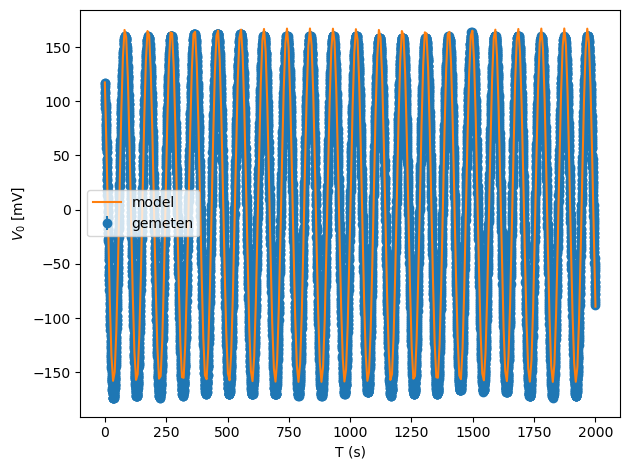

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 39405327.77260101
             x: [ 6.666e-02  1.434e+02  7.103e+00  6.452e+00]
           nit: 301
          nfev: 505
 final_simplex: (array([[ 6.666e-02,  1.434e+02,  7.103e+00,  6.452e+00],
                       [ 6.666e-02,  1.434e+02,  7.103e+00,  6.452e+00],
                       ...,
                       [ 6.666e-02,  1.434e+02,  7.103e+00,  6.452e+00],
                       [ 6.666e-02,  1.434e+02,  7.103e+00,  6.452e+00]]), array([ 3.941e+07,  3.941e+07,  3.941e+07,  3.941e+07,
                        3.941e+07]))
[[0.0005475088861254102, 0.06665991664764517], [143.39877997083525, 143.404931382298], [-5.462940612030193, 19.66984320190357], [6.449870607546975, 6.4542043929523905]]
omega heeft als waarde: 0.06666 + 1.8409e-08 - 0.066112 met 68% betrouwbaarheidsinterval: [0.00054751, 0.06666] 
p_0_x heeft als waarde: 143.4 + 0.0030739 - 0.0030775 met 68% b

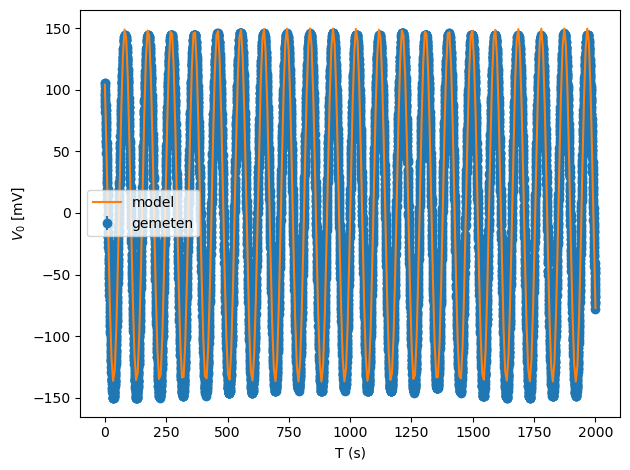

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 13884334.716292916
             x: [ 6.666e-02  9.219e+01  7.087e+00  1.534e+01]
           nit: 271
          nfev: 463
 final_simplex: (array([[ 6.666e-02,  9.219e+01,  7.087e+00,  1.534e+01],
                       [ 6.666e-02,  9.219e+01,  7.087e+00,  1.534e+01],
                       ...,
                       [ 6.666e-02,  9.219e+01,  7.087e+00,  1.534e+01],
                       [ 6.666e-02,  9.219e+01,  7.087e+00,  1.534e+01]]), array([ 1.388e+07,  1.388e+07,  1.388e+07,  1.388e+07,
                        1.388e+07]))
[[0.0005632271294490679, 0.06665523846150131], [92.18695655437871, 92.19310780083451], [-5.47988543678935, 19.652922033430315], [15.339026608380346, 15.343360393974908]]
omega heeft als waarde: 0.066655 + -2.864e-08 - 0.066092 met 68% betrouwbaarheidsinterval: [0.00056323, 0.066655] 
p_0_x heeft als waarde: 92.19 + 0.0030813 - 0.00307 met 68%

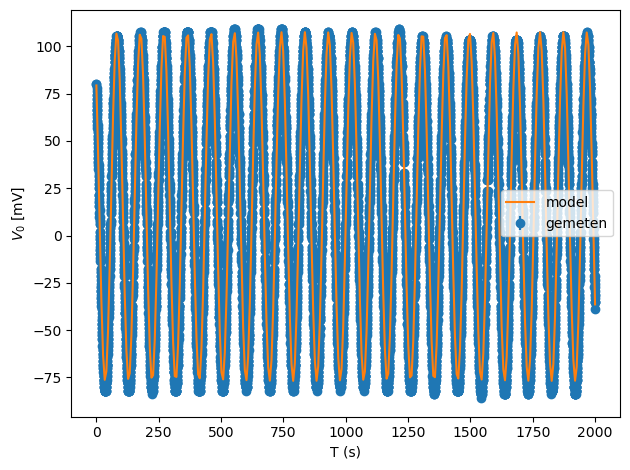

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1324736841.7899675
             x: [ 7.117e-02  1.123e+01  5.821e+00  1.312e+01]
           nit: 219
          nfev: 377
 final_simplex: (array([[ 7.117e-02,  1.123e+01,  5.821e+00,  1.312e+01],
                       [ 7.117e-02,  1.123e+01,  5.821e+00,  1.312e+01],
                       ...,
                       [ 7.117e-02,  1.123e+01,  5.821e+00,  1.312e+01],
                       [ 7.117e-02,  1.123e+01,  5.821e+00,  1.312e+01]]), array([ 1.325e+09,  1.325e+09,  1.325e+09,  1.325e+09,
                        1.325e+09]))
[[0.035000920453689195, 0.10594026411039528], [11.228992818024405, 11.235103985708175], [12.104778572647081, -0.46213929588543473], [13.115853059845737, 13.12018684835192]]
omega heeft als waarde: 0.071175 + 0.034766 - 0.036174 met 68% betrouwbaarheidsinterval: [0.035001, 0.10594] 
p_0_x heeft als waarde: 11.232 + 0.0030579 - 0.0030533 met 68

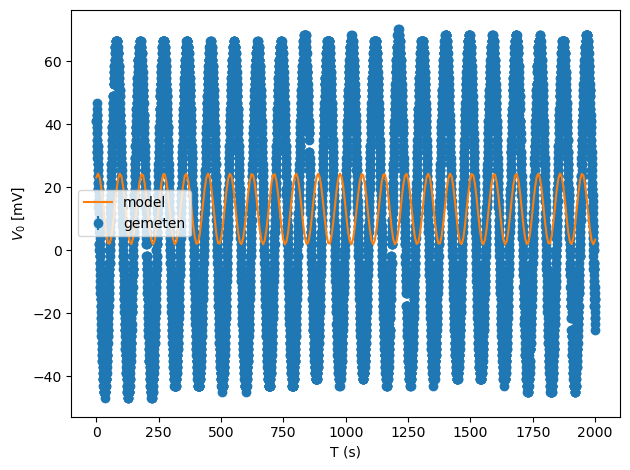

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 46666000.47293257
             x: [ 6.664e-02  1.544e+02  7.185e+00 -1.030e+00]
           nit: 284
          nfev: 490
 final_simplex: (array([[ 6.664e-02,  1.544e+02,  7.185e+00, -1.030e+00],
                       [ 6.664e-02,  1.544e+02,  7.185e+00, -1.030e+00],
                       ...,
                       [ 6.664e-02,  1.544e+02,  7.185e+00, -1.030e+00],
                       [ 6.664e-02,  1.544e+02,  7.185e+00, -1.030e+00]]), array([ 4.667e+07,  4.667e+07,  4.667e+07,  4.667e+07,
                        4.667e+07]))
[[0.011816263287097136, 0.06663527936228698], [154.38667722958766, 154.39282854743757], [0.9015744927220762, 13.467984661121028], [-1.0320524153780244, -1.0277186161456688]]
omega heeft als waarde: 0.066635 + -1.7139e-08 - 0.054819 met 68% betrouwbaarheidsinterval: [0.011816, 0.066635] 
p_0_x heeft als waarde: 154.39 + 0.0030753 - 0.003076 met

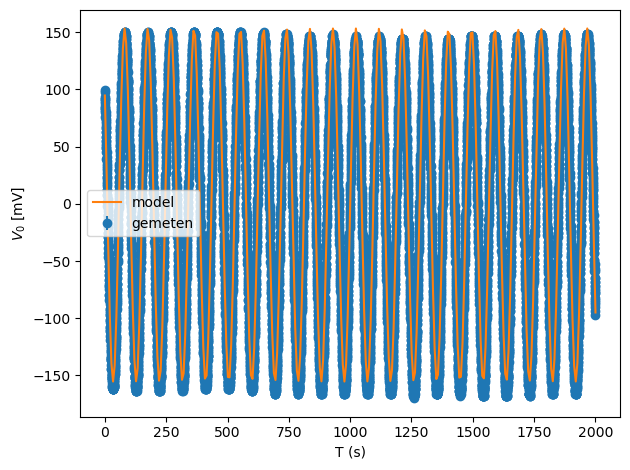

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4845045.81189076
             x: [ 6.665e-02  1.268e+01  2.072e+00  1.265e+01]
           nit: 271
          nfev: 460
 final_simplex: (array([[ 6.665e-02,  1.268e+01,  2.072e+00,  1.265e+01],
                       [ 6.665e-02,  1.268e+01,  2.072e+00,  1.265e+01],
                       ...,
                       [ 6.665e-02,  1.268e+01,  2.072e+00,  1.265e+01],
                       [ 6.665e-02,  1.268e+01,  2.072e+00,  1.265e+01]]), array([ 4.845e+06,  4.845e+06,  4.845e+06,  4.845e+06,
                        4.845e+06]))
[[0.3344122394099338, 0.04712031805317333], [12.677224189964248, 12.683337152908088], [2.071761996306663, 2.0722466047394814], [12.652207220657647, 12.656541011221748]]
omega heeft als waarde: 0.066648 + -0.019528 - -0.26776 met 68% betrouwbaarheidsinterval: [0.33441, 0.04712] 
p_0_x heeft als waarde: 12.68 + 0.0030626 - 0.0030504 met 68% betro

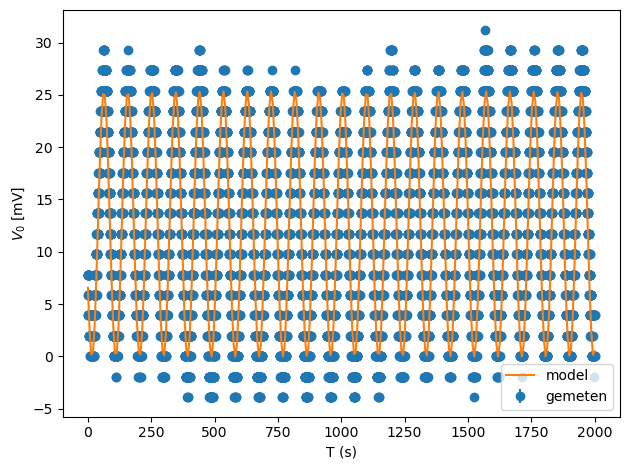

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 494672308.19372267
             x: [ 7.117e-02 -6.826e+00  3.075e+00  8.167e+00]
           nit: 227
          nfev: 390
 final_simplex: (array([[ 7.117e-02, -6.826e+00,  3.075e+00,  8.167e+00],
                       [ 7.117e-02, -6.826e+00,  3.075e+00,  8.167e+00],
                       ...,
                       [ 7.117e-02, -6.826e+00,  3.075e+00,  8.167e+00],
                       [ 7.117e-02, -6.826e+00,  3.075e+00,  8.167e+00]]), array([ 4.947e+08,  4.947e+08,  4.947e+08,  4.947e+08,
                        4.947e+08]))
[[0.03502183070592195, 0.09960180834406221], [-6.829314059383832, -6.823196823096186], [3.074628377065164, 3.075527939059726], [8.164345801521524, 8.168679587911718]]
omega heeft als waarde: 0.071171 + 0.02843 - 0.03615 met 68% betrouwbaarheidsinterval: [0.035022, 0.099602] 
p_0_x heeft als waarde: -6.8263 + 0.0030623 - 0.003055 met 68% betro

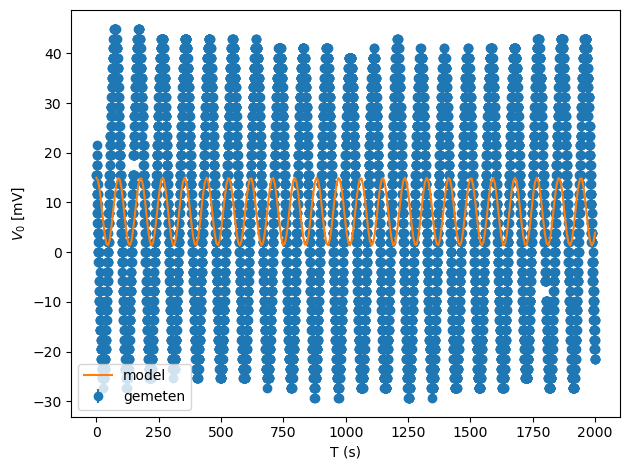

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10755794.648618732
             x: [ 6.666e-02  6.892e+01  7.280e+00  5.448e+00]
           nit: 256
          nfev: 434
 final_simplex: (array([[ 6.666e-02,  6.892e+01,  7.280e+00,  5.448e+00],
                       [ 6.666e-02,  6.892e+01,  7.280e+00,  5.448e+00],
                       ...,
                       [ 6.666e-02,  6.892e+01,  7.280e+00,  5.448e+00],
                       [ 6.666e-02,  6.892e+01,  7.280e+00,  5.448e+00]]), array([ 1.076e+07,  1.076e+07,  1.076e+07,  1.076e+07,
                        1.076e+07]))
[[0.0004287728280428667, 0.06665691372274998], [68.91677953663054, 68.92293045741764], [0.9970115405586856, 13.563382154924847], [5.446228543559617, 5.450562339576271]]
omega heeft als waarde: 0.066657 + 3.8287e-08 - 0.066228 met 68% betrouwbaarheidsinterval: [0.00042877, 0.066657] 
p_0_x heeft als waarde: 68.92 + 0.0030743 - 0.0030766 met 68

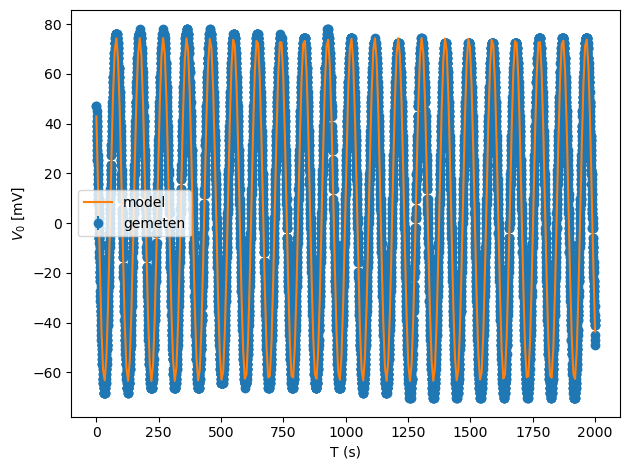

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 21605010.672992777
             x: [ 6.666e-02  1.065e+02  7.228e+00  3.488e+00]
           nit: 244
          nfev: 409
 final_simplex: (array([[ 6.666e-02,  1.065e+02,  7.228e+00,  3.488e+00],
                       [ 6.666e-02,  1.065e+02,  7.228e+00,  3.488e+00],
                       ...,
                       [ 6.666e-02,  1.065e+02,  7.228e+00,  3.488e+00],
                       [ 6.666e-02,  1.065e+02,  7.228e+00,  3.488e+00]]), array([ 2.161e+07,  2.161e+07,  2.161e+07,  2.161e+07,
                        2.161e+07]))
[[0.06665531070843583, 0.0666553107230358], [106.54496049568918, 106.55111183985815], [-5.338213925024351, 19.7944699894153], [3.4862991158771717, 3.4906329006289663]]
omega heeft als waarde: 0.066655 + 2.4818e-08 - -2.4803e-08 met 68% betrouwbaarheidsinterval: [0.066655, 0.066655] 
p_0_x heeft als waarde: 106.55 + 0.0030721 - 0.0030793 met 6

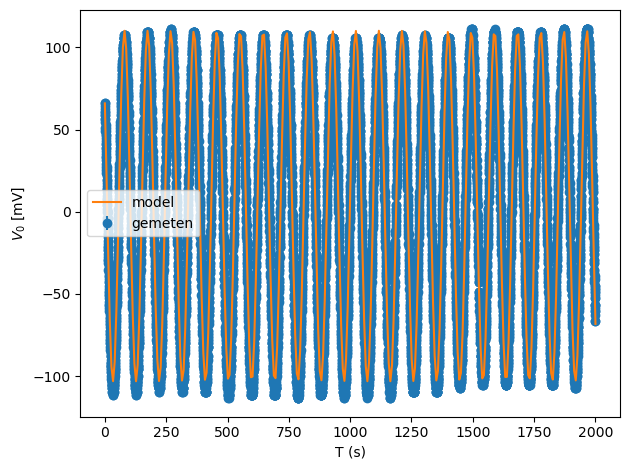

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 30849836.5561408
             x: [ 6.666e-02  1.282e+02  7.160e+00  2.443e+00]
           nit: 294
          nfev: 493
 final_simplex: (array([[ 6.666e-02,  1.282e+02,  7.160e+00,  2.443e+00],
                       [ 6.666e-02,  1.282e+02,  7.160e+00,  2.443e+00],
                       ...,
                       [ 6.666e-02,  1.282e+02,  7.160e+00,  2.443e+00],
                       [ 6.666e-02,  1.282e+02,  7.160e+00,  2.443e+00]]), array([ 3.085e+07,  3.085e+07,  3.085e+07,  3.085e+07,
                        3.085e+07]))
[[0.06666136284823172, 0.0666613628497545], [128.15924998448895, 128.1654016629997], [-11.689836287224399, 26.009227909343398], [2.4409445213802545, 2.4452783079967624]]
omega heeft als waarde: 0.066661 + 2.0586e-08 - -2.0585e-08 met 68% betrouwbaarheidsinterval: [0.066661, 0.066661] 
p_0_x heeft als waarde: 128.16 + 0.0030578 - 0.0030939 met 6

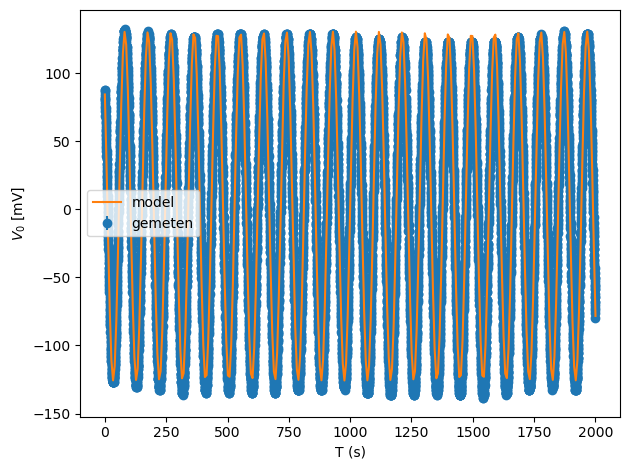

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 37107185.95922649
             x: [ 6.666e-02  1.441e+02  7.172e+00 -3.528e-01]
           nit: 323
          nfev: 545
 final_simplex: (array([[ 6.666e-02,  1.441e+02,  7.172e+00, -3.528e-01],
                       [ 6.666e-02,  1.441e+02,  7.172e+00, -3.528e-01],
                       ...,
                       [ 6.666e-02,  1.441e+02,  7.172e+00, -3.528e-01],
                       [ 6.666e-02,  1.441e+02,  7.172e+00, -3.528e-01]]), array([ 3.711e+07,  3.711e+07,  3.711e+07,  3.711e+07,
                        3.711e+07]))
[[0.0005034436640292303, 0.06665827874046124], [144.10966685339477, 144.11581839954394], [0.8885277502163798, 13.454940737733175], [-0.35497042084789826, -0.3506366303521571]]
omega heeft als waarde: 0.066658 + 1.8366e-08 - 0.066155 met 68% betrouwbaarheidsinterval: [0.00050344, 0.066658] 
p_0_x heeft als waarde: 144.11 + 0.0030793 - 0.0030722

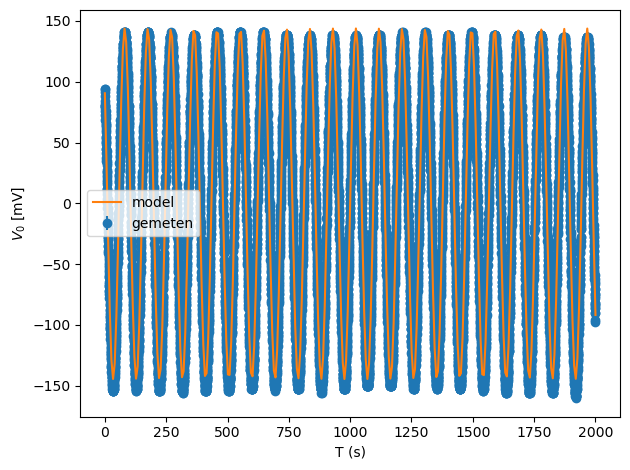

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 49087760.47179764
             x: [ 6.664e-02  1.557e+02  7.148e+00  2.232e+00]
           nit: 352
          nfev: 601
 final_simplex: (array([[ 6.664e-02,  1.557e+02,  7.148e+00,  2.232e+00],
                       [ 6.664e-02,  1.557e+02,  7.148e+00,  2.232e+00],
                       ...,
                       [ 6.664e-02,  1.557e+02,  7.148e+00,  2.232e+00],
                       [ 6.664e-02,  1.557e+02,  7.148e+00,  2.232e+00]]), array([ 4.909e+07,  4.909e+07,  4.909e+07,  4.909e+07,
                        4.909e+07]))
[[0.0118319333656489, 0.06663861258112364], [155.6626776360911, 155.66882894051153], [-55.68352807587049, 25.997880918268983], [2.229789774659096, 2.234123561472041]]
omega heeft als waarde: 0.066639 + -1.6989e-08 - 0.054807 met 68% betrouwbaarheidsinterval: [0.011832, 0.066639] 
p_0_x heeft als waarde: 155.67 + 0.0030734 - 0.0030779 met 68% b

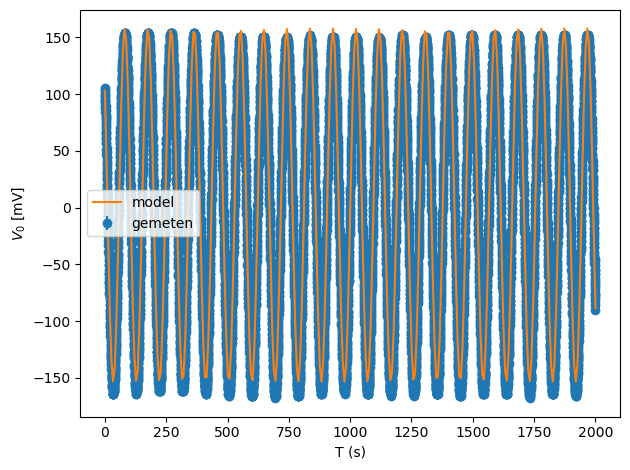

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 44960392.55966081
             x: [ 6.664e-02  1.535e+02  7.120e+00  4.525e+00]
           nit: 322
          nfev: 554
 final_simplex: (array([[ 6.664e-02,  1.535e+02,  7.120e+00,  4.525e+00],
                       [ 6.664e-02,  1.535e+02,  7.120e+00,  4.525e+00],
                       ...,
                       [ 6.664e-02,  1.535e+02,  7.120e+00,  4.525e+00],
                       [ 6.664e-02,  1.535e+02,  7.120e+00,  4.525e+00]]), array([ 4.496e+07,  4.496e+07,  4.496e+07,  4.496e+07,
                        4.496e+07]))
[[0.0069534530813695535, 0.06663638844229114], [153.4615651189874, 153.46771626661462], [-5.446676039562191, 19.686104983175298], [4.52326274211818, 4.527596536007092]]
omega heeft als waarde: 0.066636 + -1.7179e-08 - 0.059683 met 68% betrouwbaarheidsinterval: [0.0069535, 0.066636] 
p_0_x heeft als waarde: 153.46 + 0.0030713 - 0.0030799 met 68

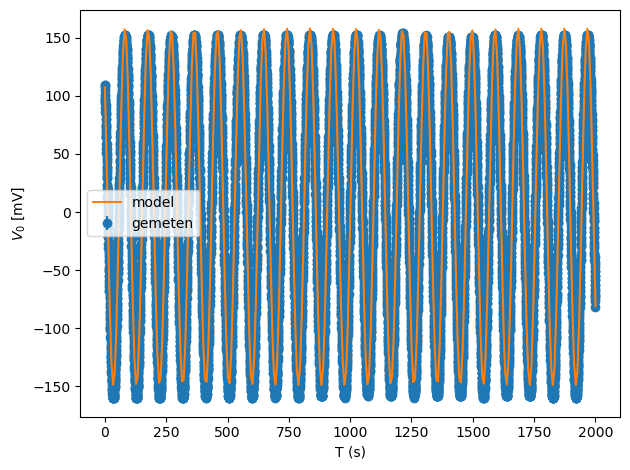

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 43757989.840260364
             x: [ 6.664e-02  1.451e+02  7.146e+00  6.023e+00]
           nit: 319
          nfev: 547
 final_simplex: (array([[ 6.664e-02,  1.451e+02,  7.146e+00,  6.023e+00],
                       [ 6.664e-02,  1.451e+02,  7.146e+00,  6.023e+00],
                       ...,
                       [ 6.664e-02,  1.451e+02,  7.146e+00,  6.023e+00],
                       [ 6.664e-02,  1.451e+02,  7.146e+00,  6.023e+00]]), array([ 4.376e+07,  4.376e+07,  4.376e+07,  4.376e+07,
                        4.376e+07]))
[[0.011820576557832696, 0.06663582791136487], [145.12035122214388, 145.12650248502538], [-5.42007762747162, 25.9958489082444], [6.020553575064917, 6.0248873599688375]]
omega heeft als waarde: 0.066636 + -1.8185e-08 - 0.054815 met 68% betrouwbaarheidsinterval: [0.011821, 0.066636] 
p_0_x heeft als waarde: 145.12 + 0.0030804 - 0.0030709 met 68%

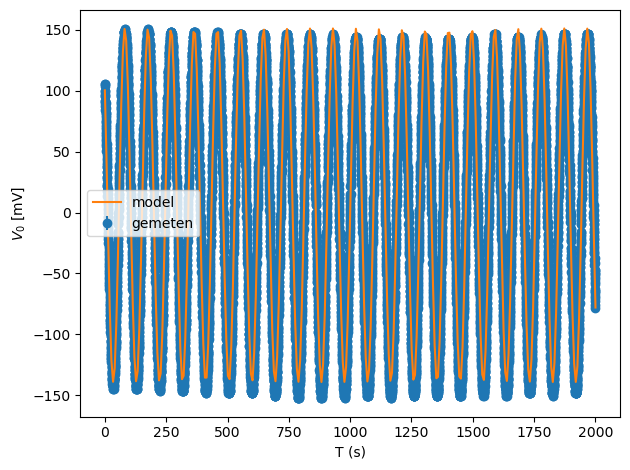

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 38538862.02318046
             x: [ 6.664e-02  1.366e+02  7.128e+00  7.347e+00]
           nit: 295
          nfev: 507
 final_simplex: (array([[ 6.664e-02,  1.366e+02,  7.128e+00,  7.347e+00],
                       [ 6.664e-02,  1.366e+02,  7.128e+00,  7.347e+00],
                       ...,
                       [ 6.664e-02,  1.366e+02,  7.128e+00,  7.347e+00],
                       [ 6.664e-02,  1.366e+02,  7.128e+00,  7.347e+00]]), array([ 3.854e+07,  3.854e+07,  3.854e+07,  3.854e+07,
                        3.854e+07]))
[[0.0005227097917842292, 0.06663869290115104], [136.60463774848313, 136.61078898601986], [-5.437929797087097, 19.694856135696337], [7.344508519903103, 7.348842330235682]]
omega heeft als waarde: 0.066639 + -1.9356e-08 - 0.066116 met 68% betrouwbaarheidsinterval: [0.00052271, 0.066639] 
p_0_x heeft als waarde: 136.61 + 0.0030691 - 0.0030821 met

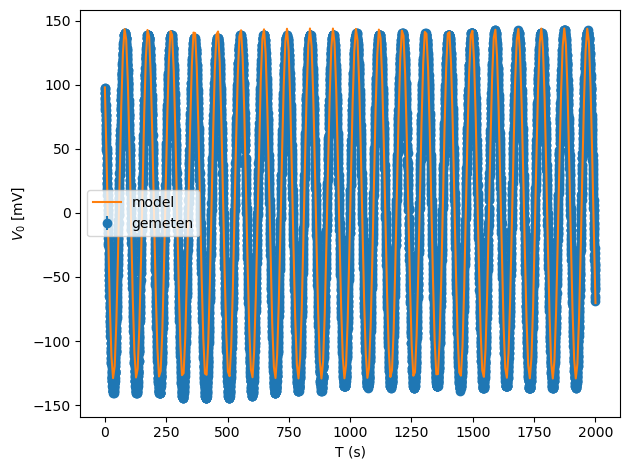

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 18817231.84853182
             x: [ 6.664e-02  1.092e+02  7.169e+00  9.717e+00]
           nit: 254
          nfev: 429
 final_simplex: (array([[ 6.664e-02,  1.092e+02,  7.169e+00,  9.717e+00],
                       [ 6.664e-02,  1.092e+02,  7.169e+00,  9.717e+00],
                       ...,
                       [ 6.664e-02,  1.092e+02,  7.169e+00,  9.717e+00],
                       [ 6.664e-02,  1.092e+02,  7.169e+00,  9.717e+00]]), array([ 1.882e+07,  1.882e+07,  1.882e+07,  1.882e+07,
                        1.882e+07]))
[[0.0004991092696565762, 0.06663597455028515], [109.23515601937318, 109.24130734339518], [0.886262031223518, 13.452688548615251], [9.714641940661702, 9.718975728020025]]
omega heeft als waarde: 0.066636 + -2.4196e-08 - 0.066137 met 68% betrouwbaarheidsinterval: [0.00049911, 0.066636] 
p_0_x heeft als waarde: 109.24 + 0.0030699 - 0.0030815 met 

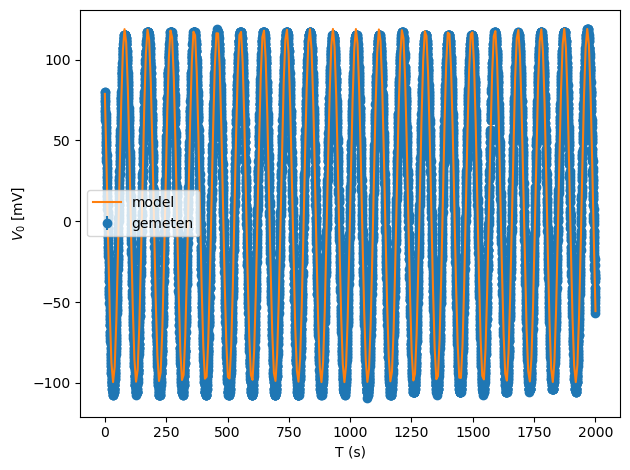

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 17394972.319388792
             x: [ 6.664e-02  9.510e+01  7.157e+00  9.922e+00]
           nit: 264
          nfev: 451
 final_simplex: (array([[ 6.664e-02,  9.510e+01,  7.157e+00,  9.922e+00],
                       [ 6.664e-02,  9.510e+01,  7.157e+00,  9.922e+00],
                       ...,
                       [ 6.664e-02,  9.510e+01,  7.157e+00,  9.922e+00],
                       [ 6.664e-02,  9.510e+01,  7.157e+00,  9.922e+00]]), array([ 1.739e+07,  1.739e+07,  1.739e+07,  1.739e+07,
                        1.739e+07]))
[[0.0005001903908228505, 0.1084442400459636], [95.09404130842765, 95.10019260637846], [-11.692446831168576, 26.006600794255533], [9.920117021494798, 9.924450809528343]]
omega heeft als waarde: 0.066635 + 0.041809 - 0.066135 met 68% betrouwbaarheidsinterval: [0.00050019, 0.10844] 
p_0_x heeft als waarde: 95.097 + 0.0030824 - 0.0030689 met 68% 

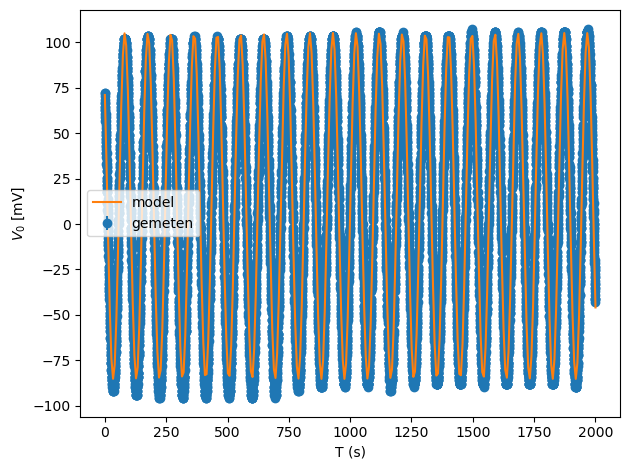

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8938099.01919262
             x: [ 6.664e-02  6.763e+01  7.234e+00  9.116e+00]
           nit: 240
          nfev: 415
 final_simplex: (array([[ 6.664e-02,  6.763e+01,  7.234e+00,  9.116e+00],
                       [ 6.664e-02,  6.763e+01,  7.234e+00,  9.116e+00],
                       ...,
                       [ 6.664e-02,  6.763e+01,  7.234e+00,  9.116e+00],
                       [ 6.664e-02,  6.763e+01,  7.234e+00,  9.116e+00]]), array([ 8.938e+06,  8.938e+06,  8.938e+06,  8.938e+06,
                        8.938e+06]))
[[0.06663567866027723, 0.0666356786606469], [67.63069461507462, 67.63684587683343], [-5.332569176746182, 19.80017205029751], [9.113383177003394, 9.117716963458715]]
omega heeft als waarde: 0.066636 + 3.909e-08 - -3.9089e-08 met 68% betrouwbaarheidsinterval: [0.066636, 0.066636] 
p_0_x heeft als waarde: 67.634 + 0.0030633 - 0.0030879 met 68% bet

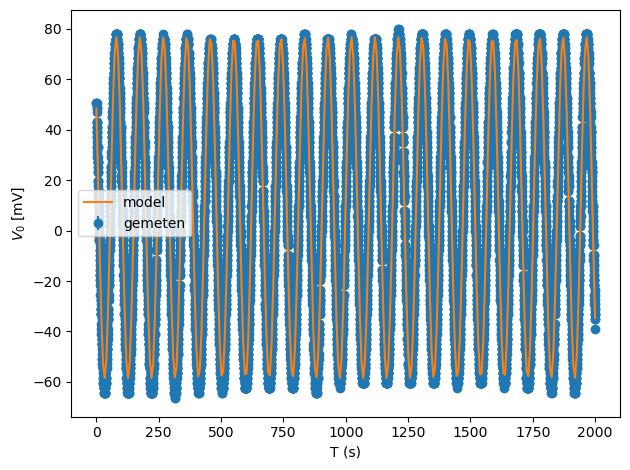

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 895829757.4874446
             x: [ 7.115e-02  9.270e+00  5.925e+00  1.251e+01]
           nit: 279
          nfev: 486
 final_simplex: (array([[ 7.115e-02,  9.270e+00,  5.925e+00,  1.251e+01],
                       [ 7.115e-02,  9.270e+00,  5.925e+00,  1.251e+01],
                       ...,
                       [ 7.115e-02,  9.270e+00,  5.925e+00,  1.251e+01],
                       [ 7.115e-02,  9.270e+00,  5.925e+00,  1.251e+01]]), array([ 8.958e+08,  8.958e+08,  8.958e+08,  8.958e+08,
                        8.958e+08]))
[[0.034956959743066486, 0.09963370510158466], [9.26676715362306, 9.272879271467623], [100.17355627372142, -31.77333518021473], [12.506097408690524, 12.51043120610697]]
omega heeft als waarde: 0.071153 + 0.028481 - 0.036196 met 68% betrouwbaarheidsinterval: [0.034957, 0.099634] 
p_0_x heeft als waarde: 9.2698 + 0.0030594 - 0.0030527 met 68% bet

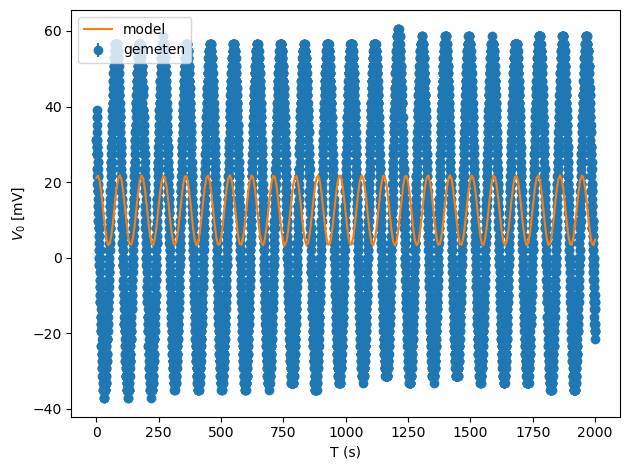

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 8299531929.653784
             x: [ 1.056e+01  1.794e+01 -7.297e+00 -6.216e+00]
           nit: 485
          nfev: 800
 final_simplex: (array([[ 1.056e+01,  1.794e+01, -7.297e+00, -6.216e+00],
                       [ 1.134e+01,  1.864e+01, -7.471e+00, -5.894e+00],
                       ...,
                       [ 1.086e+01,  1.764e+01, -7.383e+00, -6.168e+00],
                       [ 1.127e+01,  1.871e+01, -7.402e+00, -5.771e+00]]), array([ 8.300e+09,  8.303e+09,  8.306e+09,  8.313e+09,
                        8.313e+09]))
[[10.38135953221968, 10.56468609271946], [17.84546989816829, 17.940629592422923], [-19.863843880889178, -0.9360868296456312], [-6.216374901095766, -6.131594461205129]]
k heeft als waarde: 10.565 + 1.3847e-06 - 0.18333 met 68% betrouwbaarheidsinterval: [10.381, 10.565] 
p_0 heeft als waarde: 17.941 + 4.6261e-07 - 0.095159 m

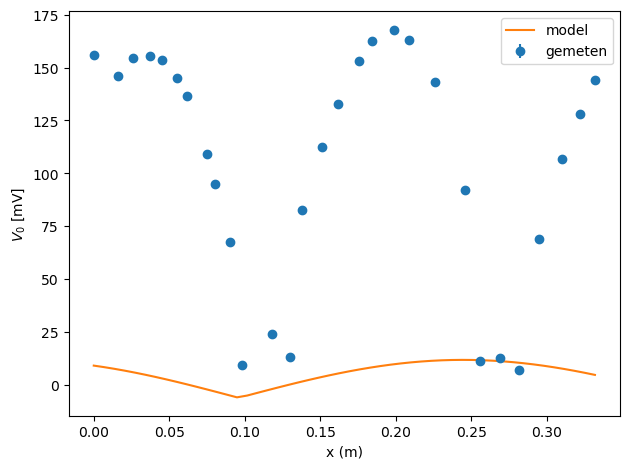

datapunt: v = [0.00630927170962566, 0.000107496715637958, 'Normaal']


In [65]:
fix_data(afstanden, T, V, V_fout, invals_vaste_x)